In [ ]:
# Loan Default Risk Modeling  
### Comparative Supervised Learning Study (Logistic vs RF vs XGBoost)

## Research Objective

This study aims to evaluate supervised learning approaches for financial default risk classification using real-world lending data. The objective is to compare linear and ensemble-based models under realistic data constraints including class imbalance, missing values, and potential feature leakage.

## Research Questions

- Can loan default risk be effectively predicted using structured financial indicators?
- How do linear and ensemble models compare in predictive performance?
- How does threshold selection impact financial risk tolerance trade-offs?

## Dataset

The dataset consists of 176,083 cleaned loan records derived from the Lending Club financial dataset. Post-outcome and leakage variables were removed to ensure realistic model generalization.

In [1]:
import os
os.getcwd()

'C:\\Users\\Talha\\Desktop\\loan-default-risk-prediction\\notebooks'

In [2]:
import pandas as pd

df = pd.read_csv(
    "../data/raw/accepted_2007_to_2018Q4.csv.gz",
    compression="gzip",
    low_memory=False,
    nrows=200000  # ilk etapta subset
)

df.shape

(200000, 151)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df["loan_status"].value_counts()

loan_status
Fully Paid            140992
Charged Off            35090
Current                22637
Late (31-120 days)       785
In Grace Period          347
Late (16-30 days)        148
Default                    1
Name: count, dtype: int64

In [5]:
df = df[df["loan_status"].isin(["Fully Paid", "Charged Off", "Default"])]

df["loan_status"].value_counts()

loan_status
Fully Paid     140992
Charged Off     35090
Default             1
Name: count, dtype: int64

In [6]:
df["target"] = df["loan_status"].apply(lambda x: 1 if x in ["Charged Off", "Default"] else 0)

df["target"].value_counts()

C:\Users\Talha\AppData\Local\Temp\ipykernel_7224\945681563.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["target"] = df["loan_status"].apply(lambda x: 1 if x in ["Charged Off", "Default"] else 0)


target
0    140992
1     35091
Name: count, dtype: int64

In [7]:
df["target"] = df["loan_status"].apply(lambda x: 1 if x in ["Charged Off", "Default"] else 0)

df["target"].value_counts()

target
0    140992
1     35091
Name: count, dtype: int64

In [8]:
df.isnull().mean().sort_values(ascending=False).head(20)

member_id                                     1.000000
sec_app_collections_12_mths_ex_med            1.000000
sec_app_chargeoff_within_12_mths              1.000000
sec_app_num_rev_accts                         1.000000
sec_app_open_act_il                           1.000000
sec_app_revol_util                            1.000000
sec_app_open_acc                              1.000000
sec_app_mort_acc                              1.000000
sec_app_mths_since_last_major_derog           1.000000
sec_app_earliest_cr_line                      1.000000
sec_app_fico_range_high                       1.000000
sec_app_inq_last_6mths                        1.000000
sec_app_fico_range_low                        1.000000
revol_bal_joint                               1.000000
next_pymnt_d                                  0.999994
desc                                          0.999943
dti_joint                                     0.997728
annual_inc_joint                              0.997723
verificati

In [9]:
df.isnull().mean().sort_values(ascending=False).head(30)

member_id                                     1.000000
sec_app_collections_12_mths_ex_med            1.000000
sec_app_chargeoff_within_12_mths              1.000000
sec_app_num_rev_accts                         1.000000
sec_app_open_act_il                           1.000000
sec_app_revol_util                            1.000000
sec_app_open_acc                              1.000000
sec_app_mort_acc                              1.000000
sec_app_mths_since_last_major_derog           1.000000
sec_app_earliest_cr_line                      1.000000
sec_app_fico_range_high                       1.000000
sec_app_inq_last_6mths                        1.000000
sec_app_fico_range_low                        1.000000
revol_bal_joint                               1.000000
next_pymnt_d                                  0.999994
desc                                          0.999943
dti_joint                                     0.997728
annual_inc_joint                              0.997723
verificati

In [10]:
missing_ratio = df.isnull().mean()

cols_to_drop = missing_ratio[missing_ratio > 0.95].index

df = df.drop(columns=cols_to_drop)

df.shape

(176083, 113)

In [11]:
df.dtypes.value_counts()

float64    88
str        23
int64       2
Name: count, dtype: int64

In [12]:
[col for col in df.columns if "rec" in col.lower()]

['mths_since_last_record',
 'pub_rec',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'pub_rec_bankruptcies']

In [13]:
[col for col in df.columns if "settlement" in col.lower()]

['debt_settlement_flag']

In [14]:
[col for col in df.columns if "pymnt" in col.lower()]

['pymnt_plan',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_d',
 'last_pymnt_amnt']

In [ ]:
## Data Cleaning and Leakage Control

Financial datasets frequently contain post-outcome variables that may artificially inflate model performance. To prevent target leakage, recovery-related, payment-related, and settlement-related variables were removed prior to model training.

High-missing variables and high-cardinality identifiers were also excluded to improve generalization and reduce overfitting risk.

In [15]:
leakage_cols = [
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "total_pymnt",
    "total_pymnt_inv",
    "last_pymnt_d",
    "last_pymnt_amnt",
    "debt_settlement_flag"
]

df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

df.shape

(176083, 103)

In [16]:
df.nunique().sort_values(ascending=False).head(15)

id                            176083
url                           176083
tot_cur_bal                   128231
tot_hi_cred_lim               126087
total_bal_ex_mort              89496
total_il_high_credit_limit     78076
emp_title                      59466
revol_bal                      46462
avg_cur_bal                    42812
bc_open_to_buy                 37583
installment                    24247
total_bal_il                   15197
annual_inc                     12764
max_bal_bc                      9905
total_rev_hi_lim                6800
dtype: int64

In [17]:
drop_cols = ["id", "url", "emp_title"]

df = df.drop(columns=[col for col in drop_cols if col in df.columns])

df.shape

(176083, 100)

In [18]:
y = df["target"]
X = df.drop(columns=["loan_status", "target"])

In [19]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

len(num_cols), len(cat_cols)

C:\Users\Talha\AppData\Local\Temp\ipykernel_7224\1411194007.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=["object"]).columns


(80, 18)

In [20]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

len(num_cols), len(cat_cols)

C:\Users\Talha\AppData\Local\Temp\ipykernel_7224\1411194007.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=["object"]).columns


(80, 18)

In [21]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "string"]).columns

len(num_cols), len(cat_cols)

(80, 18)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((140866, 98), (35217, 98))

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_reg_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [25]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_reg_model.predict(X_test)
y_proba = log_reg_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     28199
           1       0.71      0.91      0.80      7018

    accuracy                           0.91     35217
   macro avg       0.84      0.91      0.87     35217
weighted avg       0.92      0.91      0.91     35217

ROC-AUC: 0.9650722199493076


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     28199
           1       0.85      0.71      0.78      7018

    accuracy                           0.92     35217
   macro avg       0.89      0.84      0.86     35217
weighted avg       0.92      0.92      0.92     35217

ROC-AUC: 0.9587949847464319


In [27]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    log_reg_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

CV ROC-AUC scores: [0.96575933 0.96496698 0.96429708 0.96365819 0.96415911]
Mean CV ROC-AUC: 0.964568137995855


In [28]:
import numpy as np

feature_names = log_reg_model.named_steps["preprocessor"].get_feature_names_out()

coefs = log_reg_model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})

coef_df = coef_df.sort_values(by="coefficient", ascending=False)

coef_df.head(15)

,feature,coefficient
1324,cat__earliest_cr_line_Jan-1963,2.018800
1435,cat__earliest_cr_line_Jun-1972,1.784632
1285,cat__earliest_cr_line_Feb-1982,1.701442
1754,cat__last_credit_pull_d_Feb-2017,1.535437
1639,cat__earliest_cr_line_Oct-1965,1.381106
1780,cat__last_credit_pull_d_Oct-2016,1.372996
833,cat__zip_code_737xx,1.352304
1705,cat__earliest_cr_line_Sep-1978,1.350984
858,cat__zip_code_763xx,1.333781
1534,cat__earliest_cr_line_May-1967,1.262116


In [29]:
coef_df.tail(15)

,feature,coefficient
208,cat__zip_code_041xx,-1.075591
1492,cat__earliest_cr_line_Mar-1977,-1.306834
821,cat__zip_code_723xx,-1.311997
1702,cat__earliest_cr_line_Sep-1975,-1.316561
795,cat__zip_code_688xx,-1.319809
1649,cat__earliest_cr_line_Oct-1975,-1.370725
812,cat__zip_code_713xx,-1.457602
1786,cat__last_credit_pull_d_Sep-2018,-1.496086
1767,cat__last_credit_pull_d_Jun-2018,-1.500332
1281,cat__earliest_cr_line_Feb-1978,-1.502373


In [30]:
drop_more = [
    "last_credit_pull_d",
    "zip_code",
    "earliest_cr_line"
]

X = X.drop(columns=[col for col in drop_more if col in X.columns])

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "string"]).columns

In [31]:
drop_more = [
    "last_credit_pull_d",
    "zip_code",
    "earliest_cr_line"
]

X = X.drop(columns=[col for col in drop_more if col in X.columns])

# Güncel feature tiplerini tekrar al
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "string"]).columns

X.shape, len(num_cols), len(cat_cols)

((176083, 95), 80, 15)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((140866, 95), (35217, 95))

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ]
)

In [ ]:
## Model Benchmarking

To ensure robust evaluation, three supervised learning approaches were compared:

- Logistic Regression (linear baseline)
- Random Forest (bagging ensemble)
- XGBoost (boosting ensemble)

Performance was evaluated using ROC-AUC, cross-validation, confusion matrix analysis, and threshold optimization.

In [ ]:
### Logistic Regression (Linear Baseline)

Logistic Regression was used as a linear baseline model due to its interpretability and strong theoretical foundation in binary classification problems. Class imbalance was handled using balanced class weights.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)
y_proba = log_reg_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     28199
           1       0.70      0.91      0.79      7018

    accuracy                           0.90     35217
   macro avg       0.84      0.90      0.86     35217
weighted avg       0.92      0.90      0.91     35217

ROC-AUC: 0.9573697969215673


In [35]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    log_reg_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("CV ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())

CV ROC-AUC scores: [0.95902412 0.95823919 0.95695611 0.95655781 0.95661912]
Mean CV ROC-AUC: 0.9574792687558513


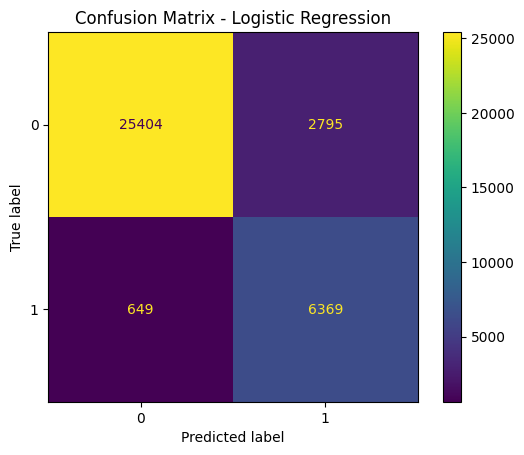

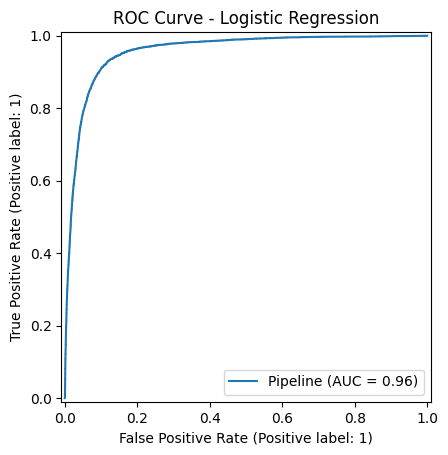

In [37]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [ ]:
### XGBoost (Boosting Ensemble)

XGBoost was applied to model complex non-linear interactions using gradient boosting. Class imbalance was addressed using scale_pos_weight.

In [38]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     28199
           1       0.69      0.92      0.79      7018

    accuracy                           0.90     35217
   macro avg       0.83      0.91      0.86     35217
weighted avg       0.92      0.90      0.91     35217

ROC-AUC: 0.960290265846717


In [39]:
from sklearn.model_selection import cross_val_score

cv_scores_xgb = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("XGB CV ROC-AUC scores:", cv_scores_xgb)
print("Mean CV ROC-AUC:", cv_scores_xgb.mean())

XGB CV ROC-AUC scores: [0.96173979 0.96122067 0.95889168 0.95960404 0.95858672]
Mean CV ROC-AUC: 0.9600085828508135


In [ ]:
### Random Forest (Bagging Ensemble)

Random Forest was implemented to capture non-linear relationships using ensemble learning through bagging. This approach reduces variance and improves robustness.

In [42]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1,
        max_depth=18,
        min_samples_leaf=10
    ))
])

rf_model.fit(X_train, y_train)

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [43]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC-AUC": [
        roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

results

,Model,ROC-AUC
0,Logistic Regression,0.957370
1,Random Forest,0.955218
2,XGBoost,0.960290


In [ ]:
### Model Comparison Interpretation

The comparative evaluation demonstrates that XGBoost achieves the highest ROC-AUC (0.960), indicating improved non-linear modeling capacity. However, Logistic Regression provides strong interpretability with minimal performance loss, making it suitable for explainable financial risk systems.

In [44]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.05)

threshold_results = []

for t in thresholds:
    y_pred_thresh = (y_proba_xgb >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    threshold_results.append((t, precision, recall, f1))

threshold_df = pd.DataFrame(
    threshold_results,
    columns=["Threshold", "Precision", "Recall", "F1"]
)

threshold_df

,Threshold,Precision,Recall,F1
0,0.10,0.494294,0.975207,0.656058
1,0.15,0.538053,0.967085,0.691422
2,0.20,0.570654,0.959818,0.715758
3,0.25,0.597039,0.953833,0.734394
4,0.30,0.619523,0.946851,0.748986
5,0.35,0.638526,0.940866,0.760758
6,0.40,0.658149,0.932174,0.771553
7,0.45,0.674948,0.925192,0.780502
8,0.50,0.688539,0.915076,0.785806
9,0.55,0.703786,0.905956,0.792175


In [ ]:
### Threshold Optimization Interpretation

The results indicate that optimal threshold values lie between 0.65–0.70, balancing recall and precision effectively. This highlights the importance of threshold tuning in financial institutions where risk tolerance varies depending on regulatory and operational constraints.

In [ ]:
## Discussion and Conclusion

The results demonstrate strong discriminative capability in predicting loan default risk.

XGBoost achieved the highest ROC-AUC (0.960), while Logistic Regression provided strong interpretability with stable cross-validation performance (0.957 ± minimal variance).

Threshold optimization revealed that recall can be significantly adjusted depending on institutional risk tolerance, highlighting the importance of precision-recall trade-offs in financial decision systems.

The stability across cross-validation folds indicates robust generalization and minimal overfitting.

This study emphasizes the importance of structured preprocessing, leakage prevention, model benchmarking, and threshold analysis in applied financial risk modeling.

In [ ]:
### Limitations and Future Work

While the current study demonstrates strong predictive performance, future work may include SHAP-based interpretability analysis, hyperparameter tuning via grid search, and cost-sensitive optimization to better simulate institutional financial risk policies.